# Text classification with movie reviews

Notebook này sẽ phân loại các nhận xét phim (chứa trong một tập dữ liệu) vào 1 trong 2 loại "*tích cực*" hoặc "*tiêu cực*". 

Đây là một ví dụ của phân loại nhị phân, hoặc phân loại 2 lớp (*binary—or two-class—classification*), vốn quan trọng và được sử dụng rộng rãi trong machine learning.

Chúng ta sẽ dùng tập dữ liệu của [IMDB](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/imdb) chứa 50,000 nhận xét về các bộ phim. Tập dữ liệu này được chia làm 2 phần, 25,000 reviews cho training, và 25,000 reviews cho testing. 

Tập training và testing được tạo một cách đồng đều, nghĩa là số lượng nhận xét tích cực và tiêu cực ở hai bên là như nhau.

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

print(tf.__version__)

1.10.0


## Download the IMDB dataset

The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

The following code downloads the IMDB dataset to your machine (or uses a cached copy if you've already downloaded it):

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words = 10000)

The argument num_words=10000 keeps the top 10,000 most frequently occurring words in the training data. The rare words are discarded to keep the size of the data manageable.

## Explore the data

Let's take a moment to understand the format of the data. The dataset comes preprocessed: each example is an array of integers representing the words of the movie review. Each label is an integer value of either 0 or 1, where 0 is a negative review, and 1 is a positive review.

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


The text of reviews have been converted to integers, where each integer represents a specific word in a dictionary. Here's what the first review looks like:

In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

Do độ dài từng câu trong train_data khác nhau, nên khi gọi ```train_data.shape``` sẽ trả về (25000,). Điều này nghĩa là train_data có tổng cộng 25000 câu (dimension thứ 1), còn dimension thứ 2 không xác định (ứng với độ dài từng câu). 

In [6]:
train_data.shape

(25000,)

### Convert the integers back to words

It may be useful to know how to convert integers back to text. Here, we'll create a helper function to query a dictionary object that contains the integer to string mapping:

In [7]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [8]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

## Prepare the data

Những reviews - vốn là những array chứa số integers, cần phải được chuyển thành "tensors" trước khi đẩy vào neural network. Việc chuyển đổi có thể thực hiện thông qua một trong những cách sau:

- Sử dụng one-hot-encode để chuyển array thành những vectors của 0 và . Ví dụ: chuỗi [3, 5] sẽ trở thành một vector 10,000 chiều với mọi phần tử đều bằng 0 trừ indices 3 và 5 (bằng 1). Đây sẽ trở thành layer thứ 1 trong network, layer dạng "Dense", có thể xử lý các data dạng "floating point vector". Cách này đòi nhiều bộ nhớ vì cần một ma trận kích thước num_words * num_reviews 
- Một cách khác, ta có thể chèn vào arrays sao cho chúng có đội dài tương tự nhau, sao đó tạo một integer tensor có kích thước max_length x num_reviews. We can use an embedding layer capable of handling this shape as the first layer in our network.

Tutorial này sử dụng cách tiếp cận thứ 2. 

In [9]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                       value= word_index["<PAD>"],
                                                       padding = 'post',
                                                       maxlen = 256)
test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value= word_index["<PAD>"],
                                                       padding = 'post',
                                                       maxlen = 256)

Lúc này mỗi câu trong train_data đều có đủ 256 phần tử (ứng với ký tự PAD). Do vậy khi gọi ```train_data.shape```, thì kết quả trả về (25000, 256) thay vì (25000,)

In [10]:
train_data.shape

(25000, 256)

In [11]:
len(train_data)

25000

In [12]:
len(train_data[0])

256

In [13]:
train_data[0]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468,   66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,
        838,  112,   50,  670,    2,    9,   35,  480,  284,    5,  150,
          4,  172,  112,  167,    2,  336,  385,   39,    4,  172, 4536,
       1111,   17,  546,   38,   13,  447,    4,  192,   50,   16,    6,
        147, 2025,   19,   14,   22,    4, 1920, 4613,  469,    4,   22,
         71,   87,   12,   16,   43,  530,   38,   76,   15,   13, 1247,
          4,   22,   17,  515,   17,   12,   16,  626,   18,    2,    5,
         62,  386,   12,    8,  316,    8,  106,    5,    4, 2223, 5244,
         16,  480,   66, 3785,   33,    4,  130,   12,   16,   38,  619,
          5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,    6,
         22,   12,  215,   28,   77,   52,    5,   14,  407,   16,   82,
          2,    8,    4,  107,  117, 5952,   15,  256,    4,    2,    7,
       3766,    5,  723,   36,   71,   43,  530,  4

## Build the model

Neural network được tạo ra nhờ việc ghép nối các layers - nghĩa là cần xác định 2 điều:
- Cần dùng bao nhiêu layer?
- Cần dùng bao nhiêu "hidden unit" với mỗi layer? 

Trong ví dụ này, input data chứa một mảng những word-indices. Label để dự đoán là 0 hoặc 1. 

In [14]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)

vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


Các layer được xếp chồng theo dãy để xây bộ phân loại:

- Layer đầu tiên thuộc dạng **Embedding**: Nhận đầu vào là một integer-encoded vocabulary, sau đó tìm kiếm embedding vector cho mõi word-index. Những vector này được cập nhật (được học) khi model được trained. Vector này thêm một chiều vào output array. Kết quả đầu ra có dimensions là: (batch, sequence, embedding).
- Layer thứ hai là dạng **GlobalAveragePooling1D** trả vể một vector có độ dài cố địch cho mỗi example bằng averaging over the sequence dimension. This allows the model can handle input of variable length, in the simplest way possible.
- This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
- The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

### Hidden units

Model trên có 2 layer trung gian, hay còn gọi là layer "ẩn".  Số lượng output (units/ nodes/ neurons) là dimension của the representational space for the layer. In other words, the amount of freedom the network is allowed when learning an internal representation.

If a model has more hidden units (a higher-dimensional representation space), and/or more layers, then the network can learn more complex representations. However, it makes the network more computationally expensive and may lead to learning unwanted patterns—patterns that improve performance on training data but not on the test data. This is called overfitting, and we'll explore it later.

### Loss function and optimizer

Mỗi model đều cần:
- một loss function
- một optimizer 
cho quá trình training.

Bởi ta đang xử lý việc phân loại hai lớp, và mô hình sẽ trả về kết quả là xác suất (một single-unit layer với sigmoid activation), ta sẽ dùng hàm loss function là **binary_crossentropy**.

Đây không phải là lựa chọn duy nhất cho loss function, ta có thể chọn **mean_squared_error** chẳng hạn. Tuy nhiên, **binary_crossentropy** thường tốt hơn cho các vấn đề liên quan đến xác suất, nó đo "khoảng cách" từ giữa các phân bố xác suất, hoặc trong trường hợp này, là giữa ground-truth distribution and the predictions.

Sau này, khi ta tìm hiểu về các vấn đề liên quan đến regression (ví dụ dự đoán giá nhà), ta sẽ xem cách sử dụng mean squared error.

Now, configure the model to use an optimizer and a loss function:

In [16]:
model.compile(optimizer=tf.train.AdamOptimizer(),
             loss='binary_crossentropy',
             metrics=['accuracy'])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a validation set by setting apart 10,000 examples from the original training data. (Tại sao không dùng tập test luôn? Bởi mục đích của ta là phát triển, và tinh chỉnh model chỉ sử dụng training data, sau đó dùng test data một lần duy nhất để đánh giá độ chính xác).


In [17]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

Train the model for 40 epochs in mini-batches of 512 samples. This is 40 iterations over all samples in the x_train and y_train tensors. While training, monitor the model's loss and accuracy on the 10,000 samples from the validation set:

In [18]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs = 40,
                   batch_size = 512,
                   validation_data = (x_val, y_val),
                   verbose = 1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 3s 183us/step - loss: 0.7073 - acc: 0.5035 - val_loss: 0.6965 - val_acc: 0.4947
Epoch 2/40
15000/15000 [==============================] - 2s 138us/step - loss: 0.6933 - acc: 0.5043 - val_loss: 0.6928 - val_acc: 0.5036
Epoch 3/40
15000/15000 [==============================] - 2s 137us/step - loss: 0.6921 - acc: 0.5386 - val_loss: 0.6921 - val_acc: 0.5032
Epoch 4/40
15000/15000 [==============================] - 2s 139us/step - loss: 0.6913 - acc: 0.5592 - val_loss: 0.6912 - val_acc: 0.5277
Epoch 5/40
15000/15000 [==============================] - 2s 147us/step - loss: 0.6903 - acc: 0.5186 - val_loss: 0.6903 - val_acc: 0.5179
Epoch 6/40
15000/15000 [==============================] - 2s 142us/step - loss: 0.6892 - acc: 0.5768 - val_loss: 0.6890 - val_acc: 0.5758
Epoch 7/40
15000/15000 [==============================] - 2s 135us/step - loss: 0.6876 - acc: 0.6160 - val_loss: 0.6875 - 

## Evaluate the model

And let's see how the model performs. Two values will be returned:
- Loss (a number which represents our error, lower values are better), and 
- accuracy.

In [19]:
results = model.evaluate(test_data, test_labels)
print(results)

25000/25000 [==============================] - 1s 37us/step
[0.30980241351127624, 0.873]


This fairly naive approach achieves an accuracy of about 87%. WIth more advanced approaches, the model should get closer to 95%.

## Create a graph of accuracy and loss over time

**model.fit()** returns a **History** object that contains a dictionary with everything that happened during training:

In [20]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

There are four entries: one for each monitored metric during training and validation. We can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:



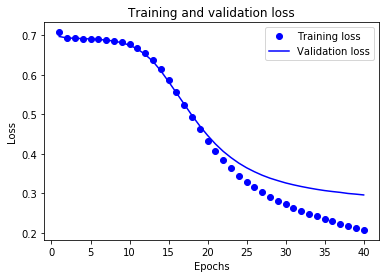

In [22]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for the "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# "b" is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

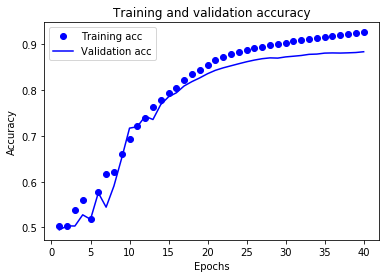

In [23]:
plt.clf() # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss decreases with each epoch and the training accuracy increases with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak after about twenty epochs. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations specific to the training data that do not generalize to test data.

For this particular case, we could prevent overfitting by simply stopping the training after twenty or so epochs. Later, you'll see how to do this automatically with a callback.

